# Variogram, Correlation and Kriging Estimation (VarioCorreKrigE): Simple Kriging and Sequential Gaussian Simulation Examples
***

In this notebook we carry out Simple Kriging on a dataset of Ground-motion residuals which are normalized as per the variance for every event ("evid") meaning that the stations/samples ("sta") corresponding to each event has a mean of zero and a standard deviation of 1. This is import for Variogram and Correlation model estimation as the sill usually tends to 1 and thus the Simple Kriging estimates becomes simpler as the variance at unsampled locations tends to 0.

There are five examples which covers the capability of the skrig function set as follows:

1) Example 1: 2D Simple Kriging utilizing a Variogram model from _variofit_ OR user-defined variogram model parameters
2) Example 2: 2D Simple Kriging utilizing a Custom model w/ user-defined pairwise distances
3) Example 3: 2D Simple Kriging w/ Sequential Gaussian Simulation (SGS) - Default using available variogram model parameters
4) Example 4: 2D Simple Kriging w/ Sequential Gaussian Simulation (SGS) - Custom model as defined in Example 2
5) Example 5: 1D Simple Kriging w/ Sequential Gaussian Simulation (SGS) - Default using available variogram model parameters

# 1.0 Import Modules and Data

## 1.1 Import Modules

### 1.1.1 General Use

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

### 1.1.2 skrig

In [2]:
from VarioCorreKrigE.utils import theta_from_params, LatLongToPolar, sample_points_from_geotiff
from VarioCorreKrigE.variofit import variofit
from VarioCorreKrigE.skrig import simple_kriging, simple_kriging_custom_corr, sgs_simple_kriging, sgs_simple_kriging_custom_corr, pairwise_distances, merge_blocks, build_blocks_all
from VarioCorreKrigE.variofit import VARIOGRAM_MODELS
from VarioCorreKrigE.correfit import CORRELATION_MODELS
print('list of variogram model: ', VARIOGRAM_MODELS)
print('list of correlation models: ', CORRELATION_MODELS)

## 1.2 Import Data

In [3]:
im_dwbar = pd.read_csv(r'Data/im_dwbar.csv')

# 2.0 Simple Kriging Example 1: Variogram Model

## 2.1 Estimation of Variogram Parameters

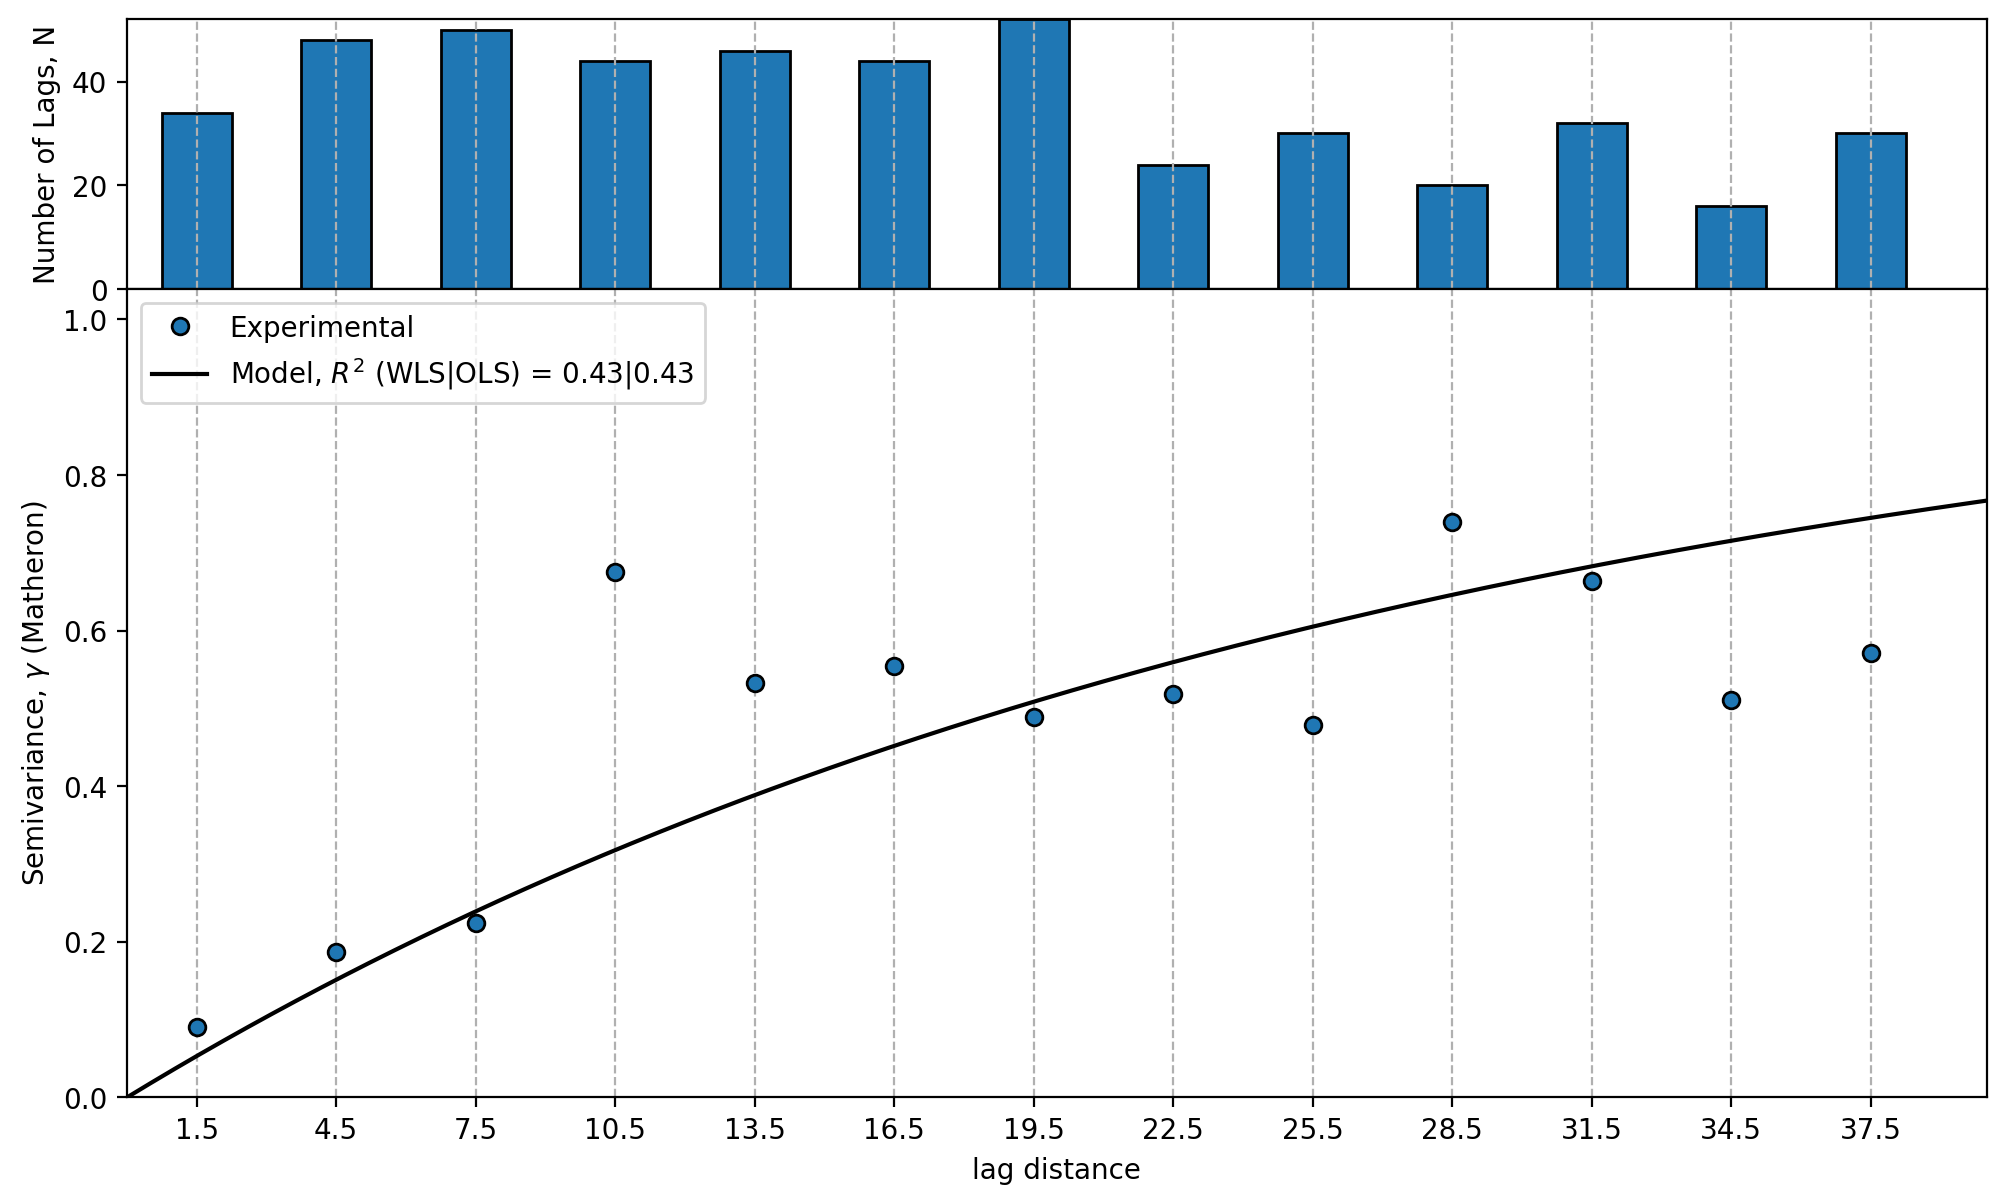

In [4]:
im_dwbar_test = im_dwbar.loc[:67]

estimator = "Matheron"
model = "exponential"
weight_fn = None
weight_params = None
xmax_factor = 100
family = 'variogram'
distance_type = 'geographic'

# get parameters/fit estiamte
h_lag, n_obs, gamma, params, r2_wls, r2_ols = variofit(values = im_dwbar_test['pSA_1.0'], coordinates = im_dwbar_test[['lat','lon']], distance_type = distance_type, max_distance = 40, bin_size = 3, estimator_type= estimator, model_type = model, weight_fn = weight_fn, weight_params = weight_params, xmax_factor=xmax_factor, fix_sill = True, plot = True)

# prepare data for kriging i.e., create target array
values = im_dwbar_test['pSA_1.0'].to_numpy(float)
coords = im_dwbar_test[['lat','lon']].to_numpy(float)

lat_lin = np.linspace(coords[:,0].min(), coords[:,0].max(), 100)
lon_lin = np.linspace(coords[:,1].min(), coords[:,1].max(), 100)
LAT, LON = np.meshgrid(lat_lin, lon_lin, indexing='ij')
targets = np.column_stack([LAT.ravel(), LON.ravel()])

theta = theta_from_params(params, model, family=family)

est, var = simple_kriging(
    values=im_dwbar_test['pSA_1.0'],
    coords=im_dwbar_test[['lat','lon']],
    targets=targets,
    model_family=family,               # or 'correlation'
    model_type=model,                       # 'exponential'
    theta=theta,
    params=params,
    distance_type=distance_type,
    mean=0,
    jitter=1e-10,
    return_weights=False
)

## 2.2 Plotting: Fitted Parameters

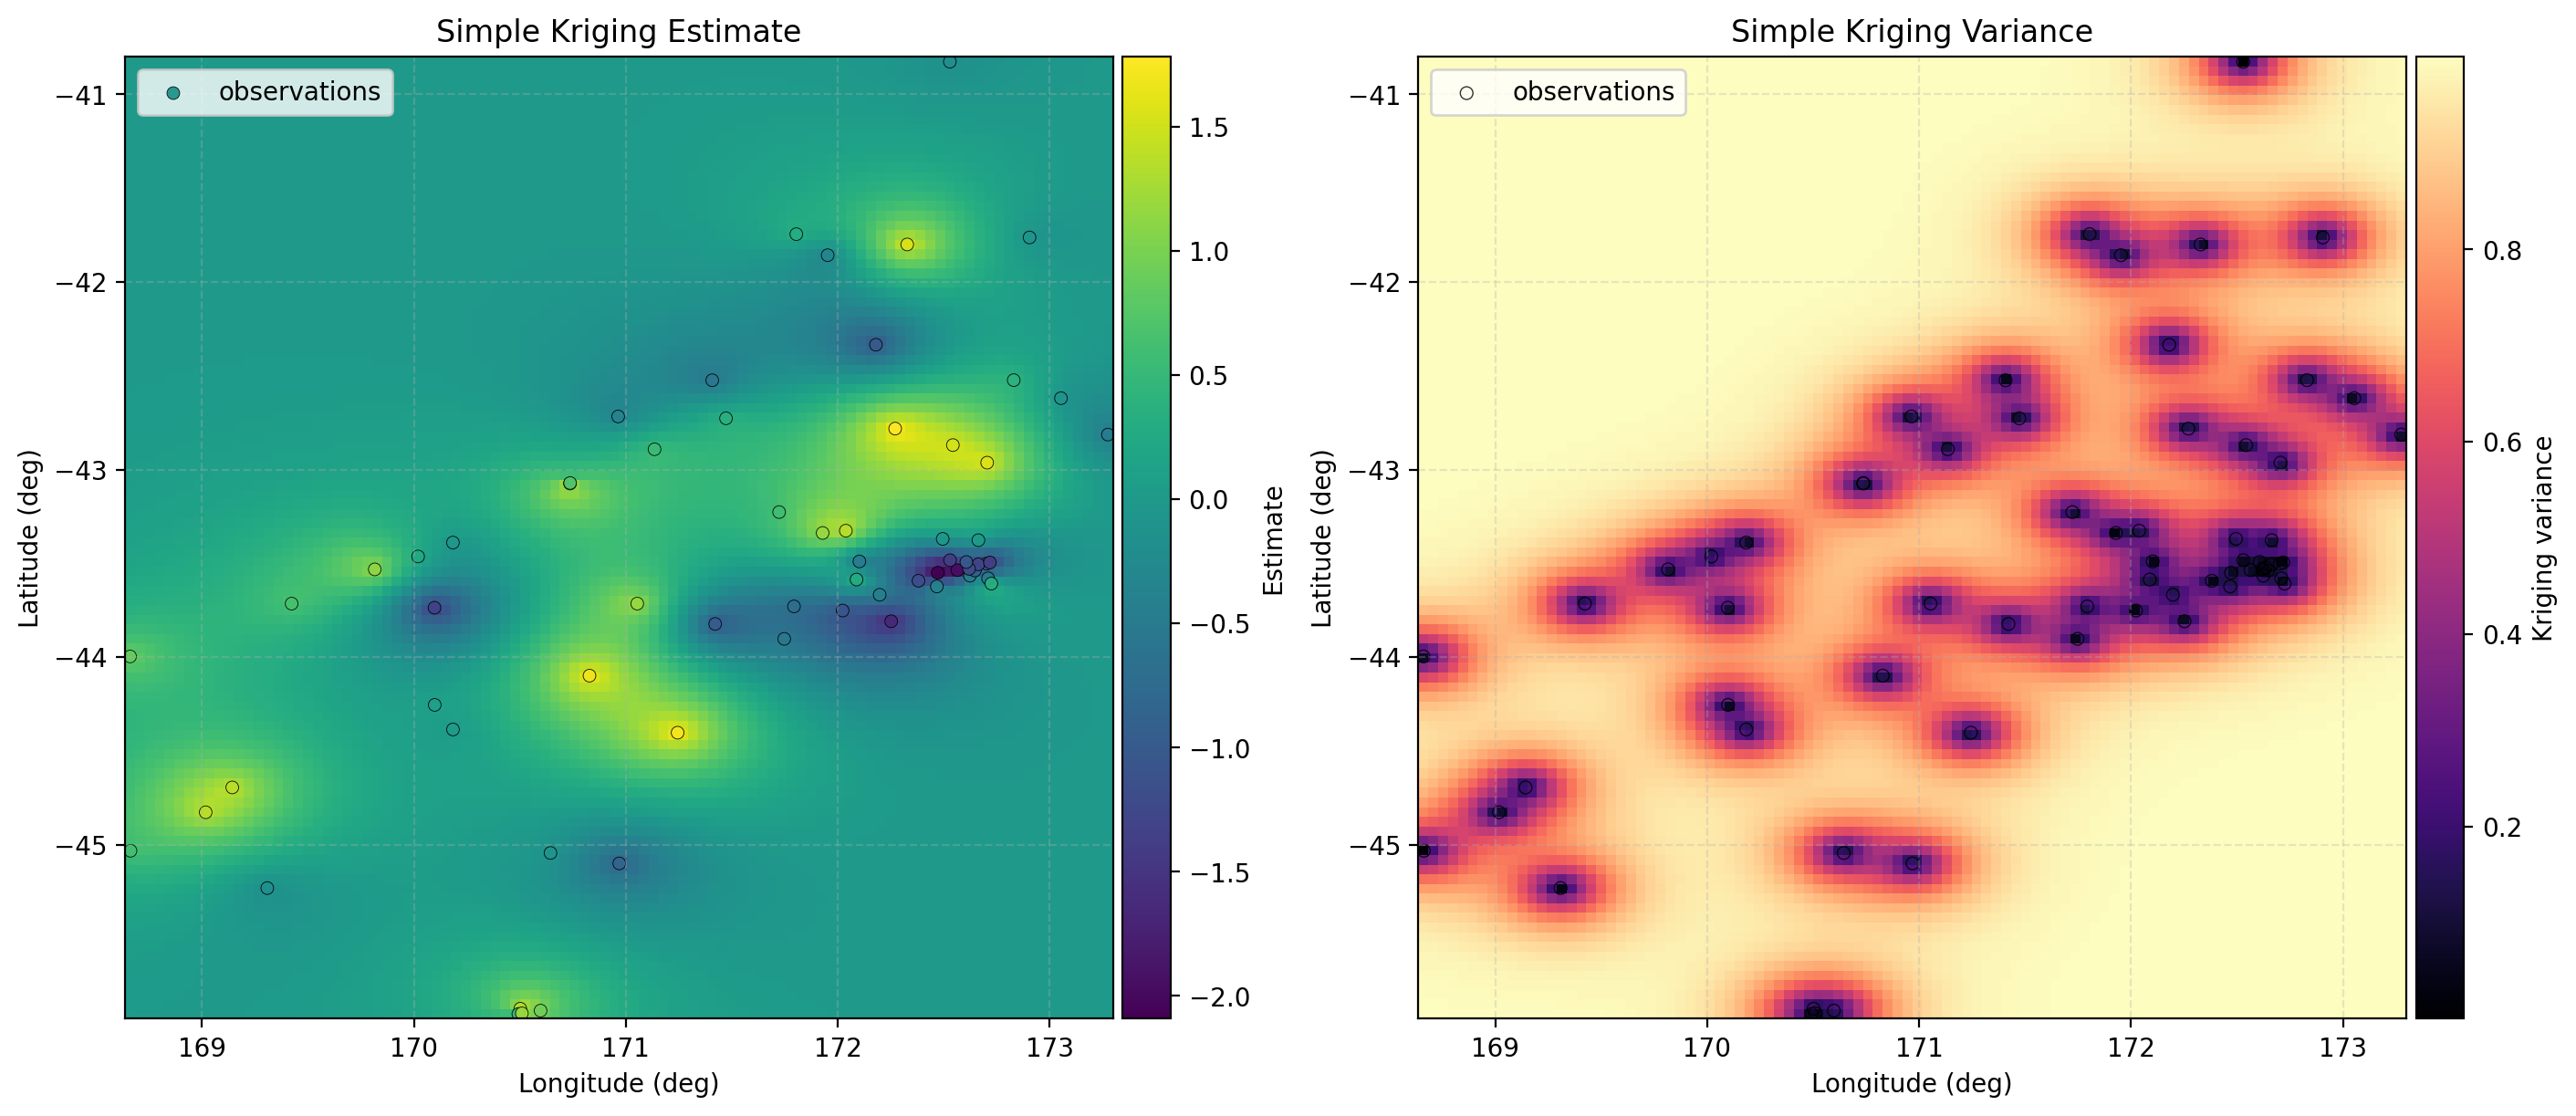

In [5]:
# reshape columnar lat/lon values for plotting on a grid
EST = est.reshape(LAT.shape)
VAR = var.reshape(LAT.shape)

vmin_est = np.nanmin([EST.min(), values.min()])
vmax_est = np.nanmax([EST.max(), values.max()])
est_norm = mpl.colors.Normalize(vmin=vmin_est, vmax=vmax_est)

cmap_est = plt.get_cmap("viridis")
cmap_var = plt.get_cmap("magma")

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=200, constrained_layout=True)
ax = axes[0]
m0 = ax.pcolormesh(LON, LAT, EST,shading="auto",cmap=cmap_est,norm=est_norm)
sc0 = ax.scatter(coords[:, 1], coords[:, 0], c=values,cmap=cmap_est,norm=est_norm, s=25, edgecolor="k", linewidths=0.3,alpha=0.95,label="observations")
cb0 = plt.colorbar(m0, ax=ax, pad=0.01, fraction=0.05)
cb0.set_label("Estimate")
ax.set_title("Simple Kriging Estimate")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(loc="upper left", frameon=True)

ax = axes[1]
m1 = ax.pcolormesh(LON, LAT, VAR,shading="auto",cmap=cmap_var)
ax.scatter(coords[:, 1], coords[:, 0],facecolors="none",edgecolors="k",s=25,linewidths=0.5,alpha=0.8,label="observations")
cb1 = plt.colorbar(m1, ax=ax, pad=0.01, fraction=0.05)
cb1.set_label("Kriging variance")
ax.set_title("Simple Kriging Variance")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(loc="upper left", frameon=True)
plt.show()

## 2.2 Plotting: Custom Parameters

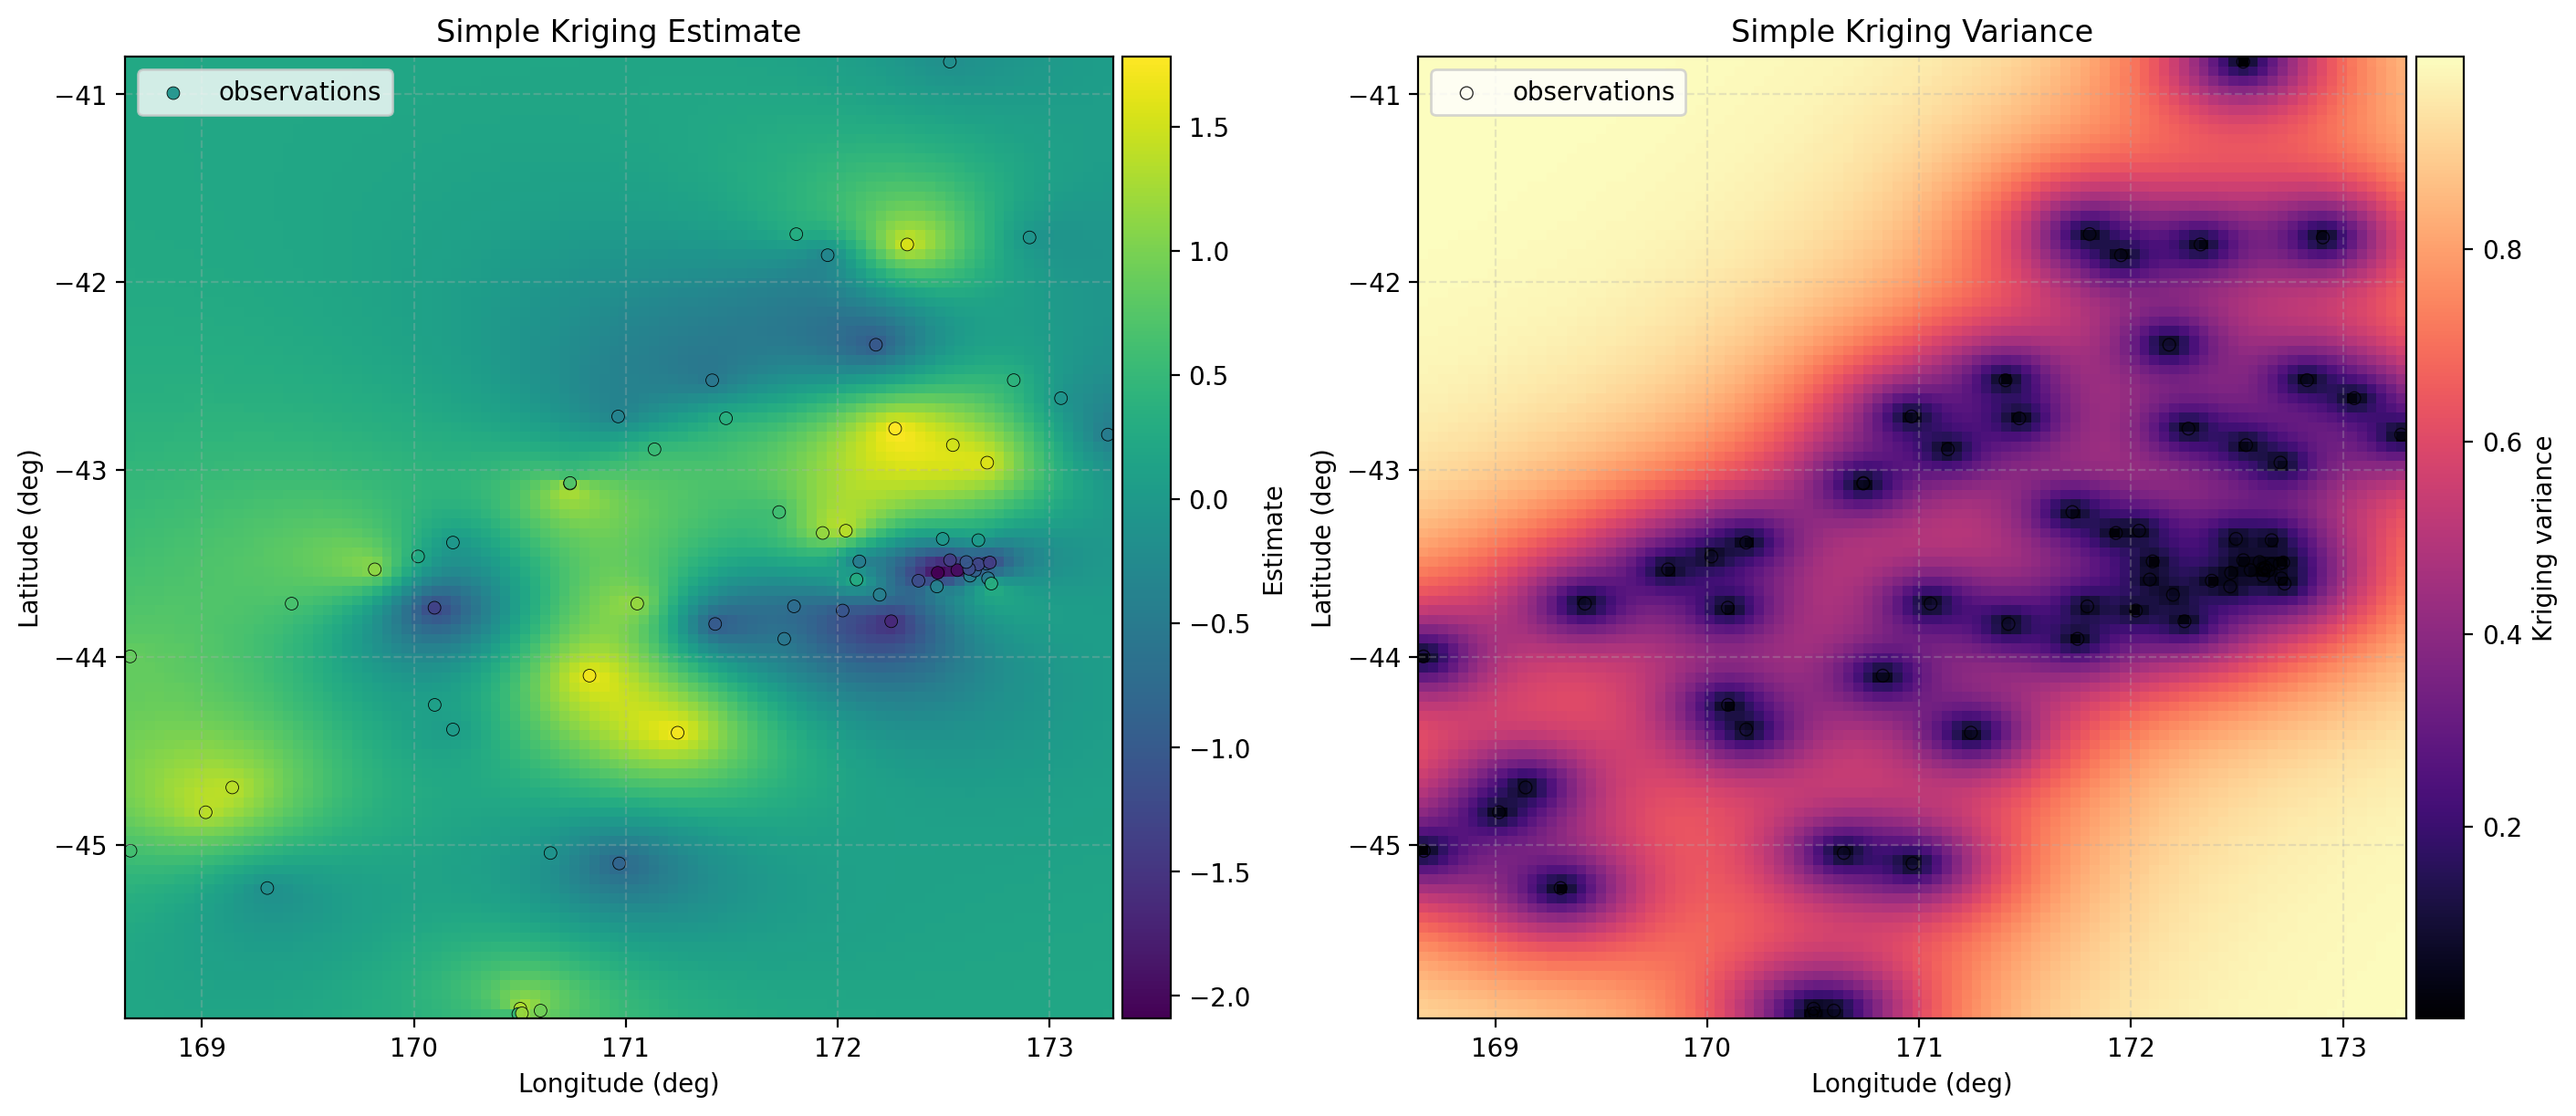

In [6]:
# custom parameters for the exponential model chosen previously
theta_2 = (200, 1.0, 0.0)
params_2 = {'r': 200, 'c0': 1.0, 'b': 0.0}

est, var = simple_kriging(
    values=im_dwbar_test['pSA_1.0'],
    coords=im_dwbar_test[['lat','lon']],
    targets=targets,
    model_family=family,               # or 'correlation'
    model_type=model,                       # 'exponential'
    theta=theta_2,
    params=params_2,
    distance_type=distance_type,
    mean='gls',
    jitter=1e-10,
    return_weights=False
)

# plot
# reshape columnar lat/lon values for plotting on a grid
EST = est.reshape(LAT.shape)
VAR = var.reshape(LAT.shape)

vmin_est = np.nanmin([EST.min(), values.min()])
vmax_est = np.nanmax([EST.max(), values.max()])
est_norm = mpl.colors.Normalize(vmin=vmin_est, vmax=vmax_est)

cmap_est = plt.get_cmap("viridis")
cmap_var = plt.get_cmap("magma")

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=200, constrained_layout=True)
ax = axes[0]
m0 = ax.pcolormesh(LON, LAT, EST,shading="auto",cmap=cmap_est,norm=est_norm)
sc0 = ax.scatter(coords[:, 1], coords[:, 0], c=values,cmap=cmap_est,norm=est_norm, s=25, edgecolor="k", linewidths=0.3,alpha=0.95,label="observations")
cb0 = plt.colorbar(m0, ax=ax, pad=0.01, fraction=0.05)
cb0.set_label("Estimate")
ax.set_title("Simple Kriging Estimate")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(loc="upper left", frameon=True)

ax = axes[1]
m1 = ax.pcolormesh(LON, LAT, VAR,shading="auto",cmap=cmap_var)
ax.scatter(coords[:, 1], coords[:, 0],facecolors="none",edgecolors="k",s=25,linewidths=0.5,alpha=0.8,label="observations")
cb1 = plt.colorbar(m1, ax=ax, pad=0.01, fraction=0.05)
cb1.set_label("Kriging variance")
ax.set_title("Simple Kriging Variance")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(loc="upper left", frameon=True)
plt.show()

# 3.0 Simple Kriging Example 2: Custom Model and Covariance Matrices

## 3.1 Define Custom Kernel

In [7]:
def kernel_MpEAS(blocks_nn, blocks_nt, theta):
    """
    MpEAS correlation: R = pE * (w*pA + (1-w)*pS)
    theta = (lE, gammaE, lA, lS, w) with 0<=w<=1
    NaN distances are treated as +inf (correlation -> 0).
    """
    lE, gammaE, lA, lS, w = map(float, theta)
    w = np.clip(w, 0.0, 1.0)

    def _safe(D):
        D = np.asarray(D, float)
        return np.where(np.isfinite(D), D, np.inf)

    def pE(D):  # exp(-(D/lE)^gammaE)
        D = _safe(D)
        return np.exp(- (D / lE)**gammaE)

    def pA(D):  # (1 + D/lA)*(1 - D/180)^(180/lA), clamp outside [0,180] -> 0
        D = _safe(D)
        base = np.maximum(0.0, 1.0 - D/180.0)
        out  = (1.0 + D/lA) * np.power(base, 180.0/lA, where=(base>0.0), out=np.zeros_like(base))
        out  = np.where((D < 0.0) | (D > 180.0), 0.0, out)
        return out

    def pS(D):  # exp(-D/lS)
        D = _safe(D)
        return np.exp(- D / lS)

    # nn blocks
    R_nn = pE(blocks_nn['E']) * (w * pA(blocks_nn['A']) + (1.0 - w) * pS(blocks_nn['S']))
    R_nn = 0.5 * (R_nn + R_nn.T)

    # nt blocks
    R_nt = pE(blocks_nt['E']) * (w * pA(blocks_nt['A']) + (1.0 - w) * pS(blocks_nt['S']))

    return R_nn, R_nt

## 3.2 Create Target arrays for Kriging

In [8]:
# create array of coordinates
lat_lin = np.linspace(min(coords[:,0]), max(coords[:,0]), 100)
lon_lin = np.linspace(min(coords[:,1]), max(coords[:,1]), 100)
LAT, LON = np.meshgrid(lat_lin, lon_lin, indexing='ij')
target_latlon = np.column_stack([LAT.ravel(), LON.ravel()])

Xevid = np.zeros_like(target_latlon)
# specify reference point e.g., Darfield Earthquake
Xevid[:,0] = -43.53
Xevid[:,1] = 172.17
Xp = LatLongToPolar(target_latlon, Xevid)
target_angular = Xp[:,1].reshape(-1,1)

# create vs30 targets
vs30_path = Path(r'D:\GIS DATA V2\NEWZEALAND\NSHM2022_NoG6G13\combined_mvn_wgs84.tif')
target_vs30 = sample_points_from_geotiff(vs30_path, target_latlon)

# get mask for invalid values
invalid = ~np.isfinite(target_vs30.ravel())

# update other arrays
target_vs30 = target_vs30[~invalid,:]
target_latlon = target_latlon[~invalid,:]
target_angular = target_angular[~invalid, :]

## 3.3 Get Pair-wise Distance

In [9]:
# site-site pairwise distances
D_nn_E, D_nt_E = pairwise_distances(coords = im_dwbar_test[['lat','lon']], targets = target_latlon, distance_type = "geographic")

# vs30 differences across sites
D_nn_S, D_nt_S = pairwise_distances(coords = im_dwbar_test[['vs30']], targets = target_vs30, distance_type = "euclidean")

# angular difference
D_nn_A, D_nt_A = pairwise_distances(coords = im_dwbar_test[['epicenter_azimuth']], targets = target_angular, distance_type = "angular")

# create dictionaries
E_nn = {'E': D_nn_E}
E_nt = {'E': D_nt_E}
S_nn = {'S': D_nn_S}
S_nt = {'S': D_nt_S}
D_nn_A = {'A': D_nn_A}
D_nt_A = {'A': D_nt_A}

blocks_nn, blocks_nt = merge_blocks([E_nn, S_nn, D_nn_A], [E_nt, S_nt, D_nt_A])

## 3.4 Compute Kriging Estimate

In [10]:
theta = (40, 0.4, 20, 169, 0.4)
sigma2_corr = float(np.var(values, ddof=1))

est, var = simple_kriging_custom_corr(
    values, blocks_nn, blocks_nt,
    custom_kernel=kernel_MpEAS,
    theta=theta,
    sigma2=sigma2_corr,
    mean='gls',  # or 0.0
    jitter=1e-10,
    return_weights=False
)

## 3.5 Plot of results

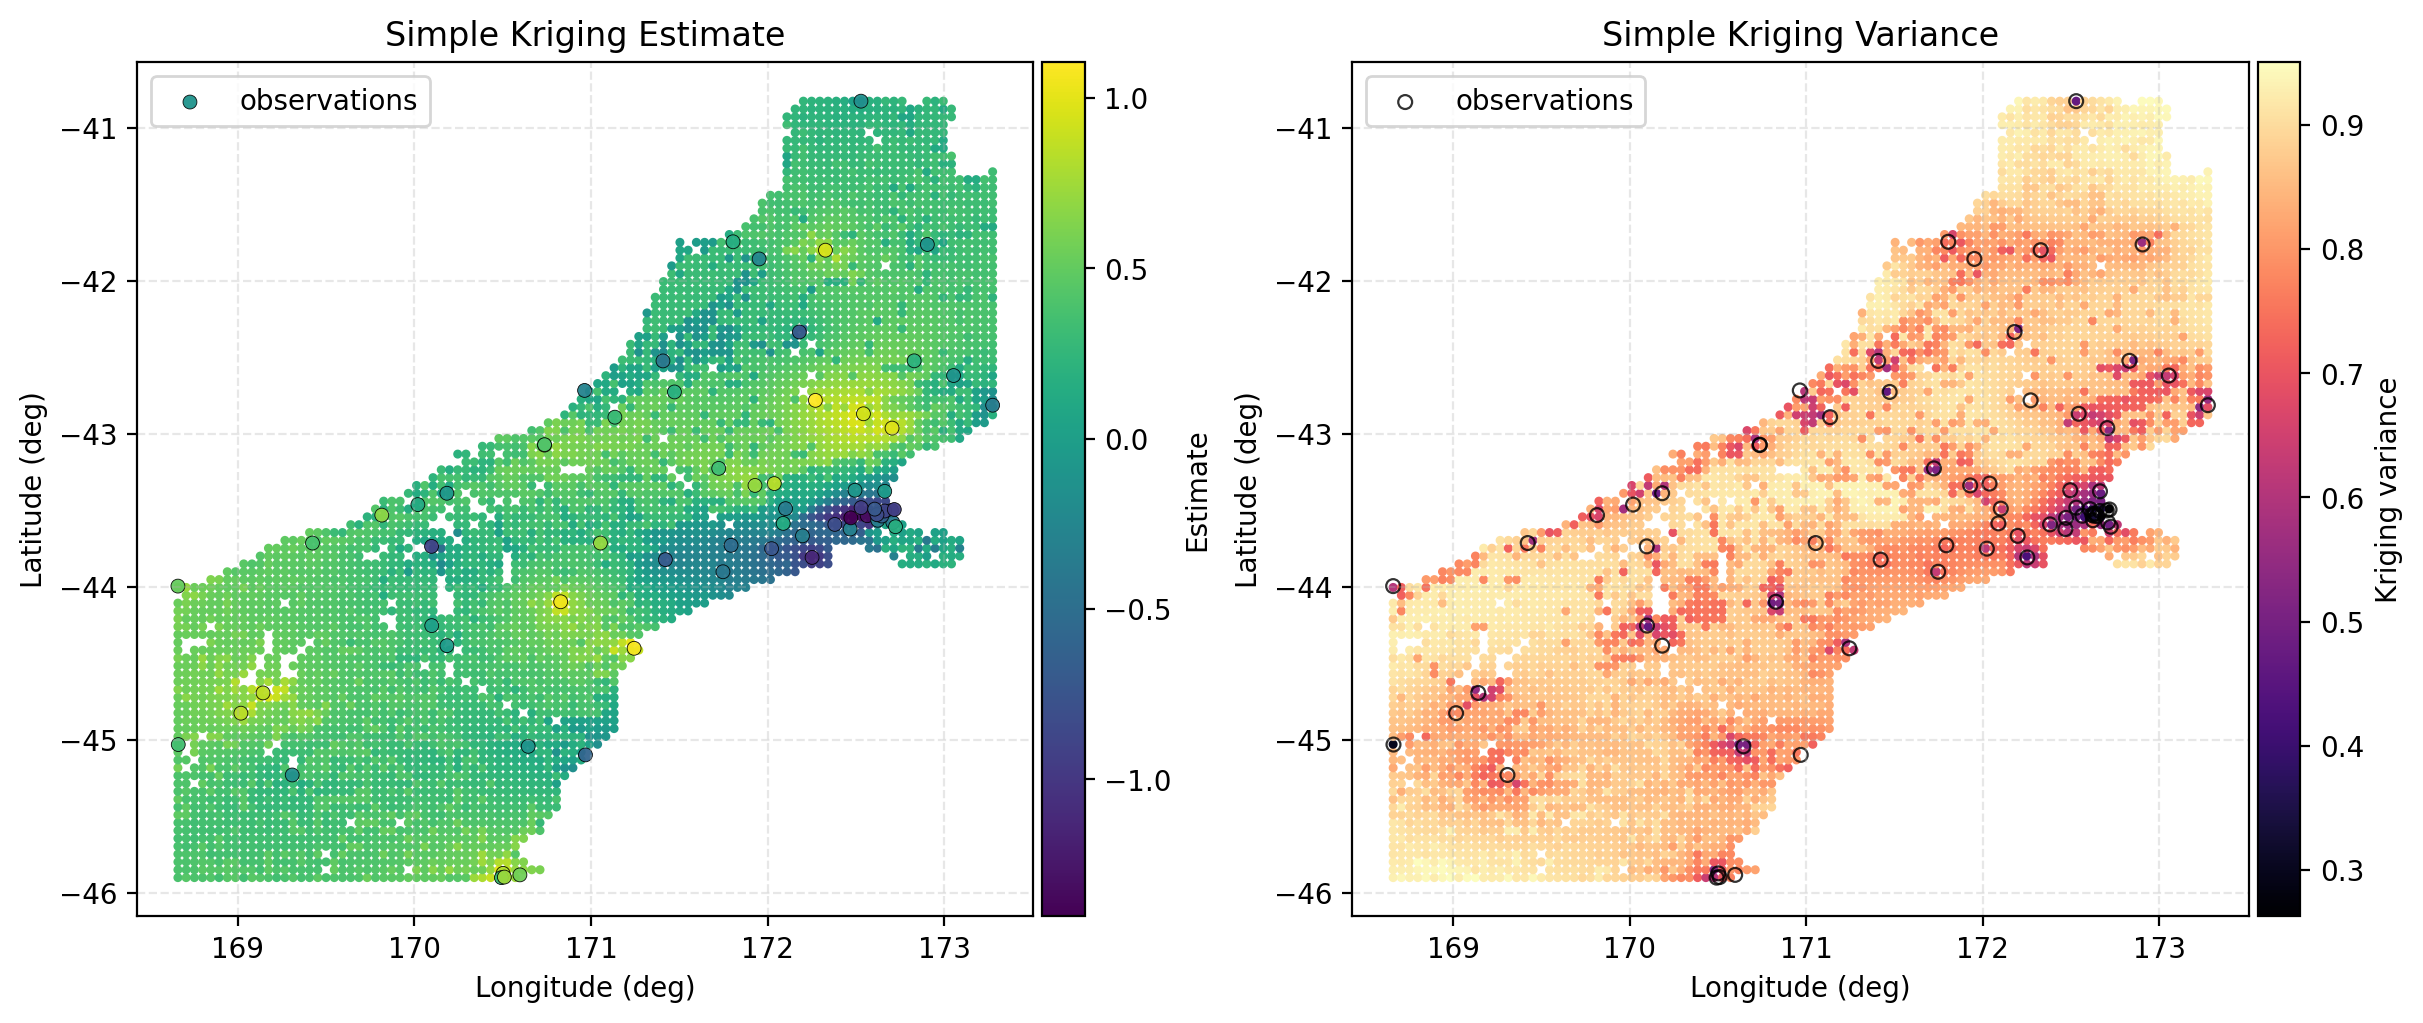

In [11]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(12,5), dpi=200, constrained_layout=True)
sc0 = ax[0].scatter(target_latlon[:, 1], target_latlon[:, 0], c=est, cmap='viridis', s=5)
ax[0].scatter(coords[:, 1], coords[:, 0], c=values, cmap='viridis', s=25, edgecolor="k", linewidths=0.3, alpha=0.95, label="observations")
cb0 = plt.colorbar(sc0, ax=ax[0], pad=0.01, fraction=0.05)
cb0.set_label("Estimate")
ax[0].set_title("Simple Kriging Estimate")
ax[0].set_xlabel("Longitude (deg)")
ax[0].set_ylabel("Latitude (deg)")
ax[0].grid(True, linestyle="--", alpha=0.3)
ax[0].legend(loc="upper left", frameon=True)

# variance
sc1 = ax[1].scatter(target_latlon[:, 1], target_latlon[:, 0], c=var, cmap='magma', s=5)
ax[1].scatter(coords[:, 1], coords[:, 0],facecolors="none", edgecolors="k",s=25,linewidths=0.8,alpha=0.8,label="observations")
cb1 = plt.colorbar(sc1, ax=ax[1], pad=0.01, fraction=0.05)
cb1.set_label("Kriging variance")
ax[1].set_title("Simple Kriging Variance")
ax[1].set_xlabel("Longitude (deg)")
ax[1].set_ylabel("Latitude (deg)")
ax[1].grid(True, linestyle="--", alpha=0.3)
ax[1].legend(loc="upper left", frameon=True)
plt.show(fig)

# 4.0 Simple Kriging Example 3: Sequential Gaussian Simulation (Default)

SGS realizations:   0%|          | 0/4 [00:00<?, ?it/s]

nodes (realization 1/4):   0%|          | 0/625 [00:00<?, ?it/s]

nodes (realization 2/4):   0%|          | 0/625 [00:00<?, ?it/s]

nodes (realization 3/4):   0%|          | 0/625 [00:00<?, ?it/s]

nodes (realization 4/4):   0%|          | 0/625 [00:00<?, ?it/s]

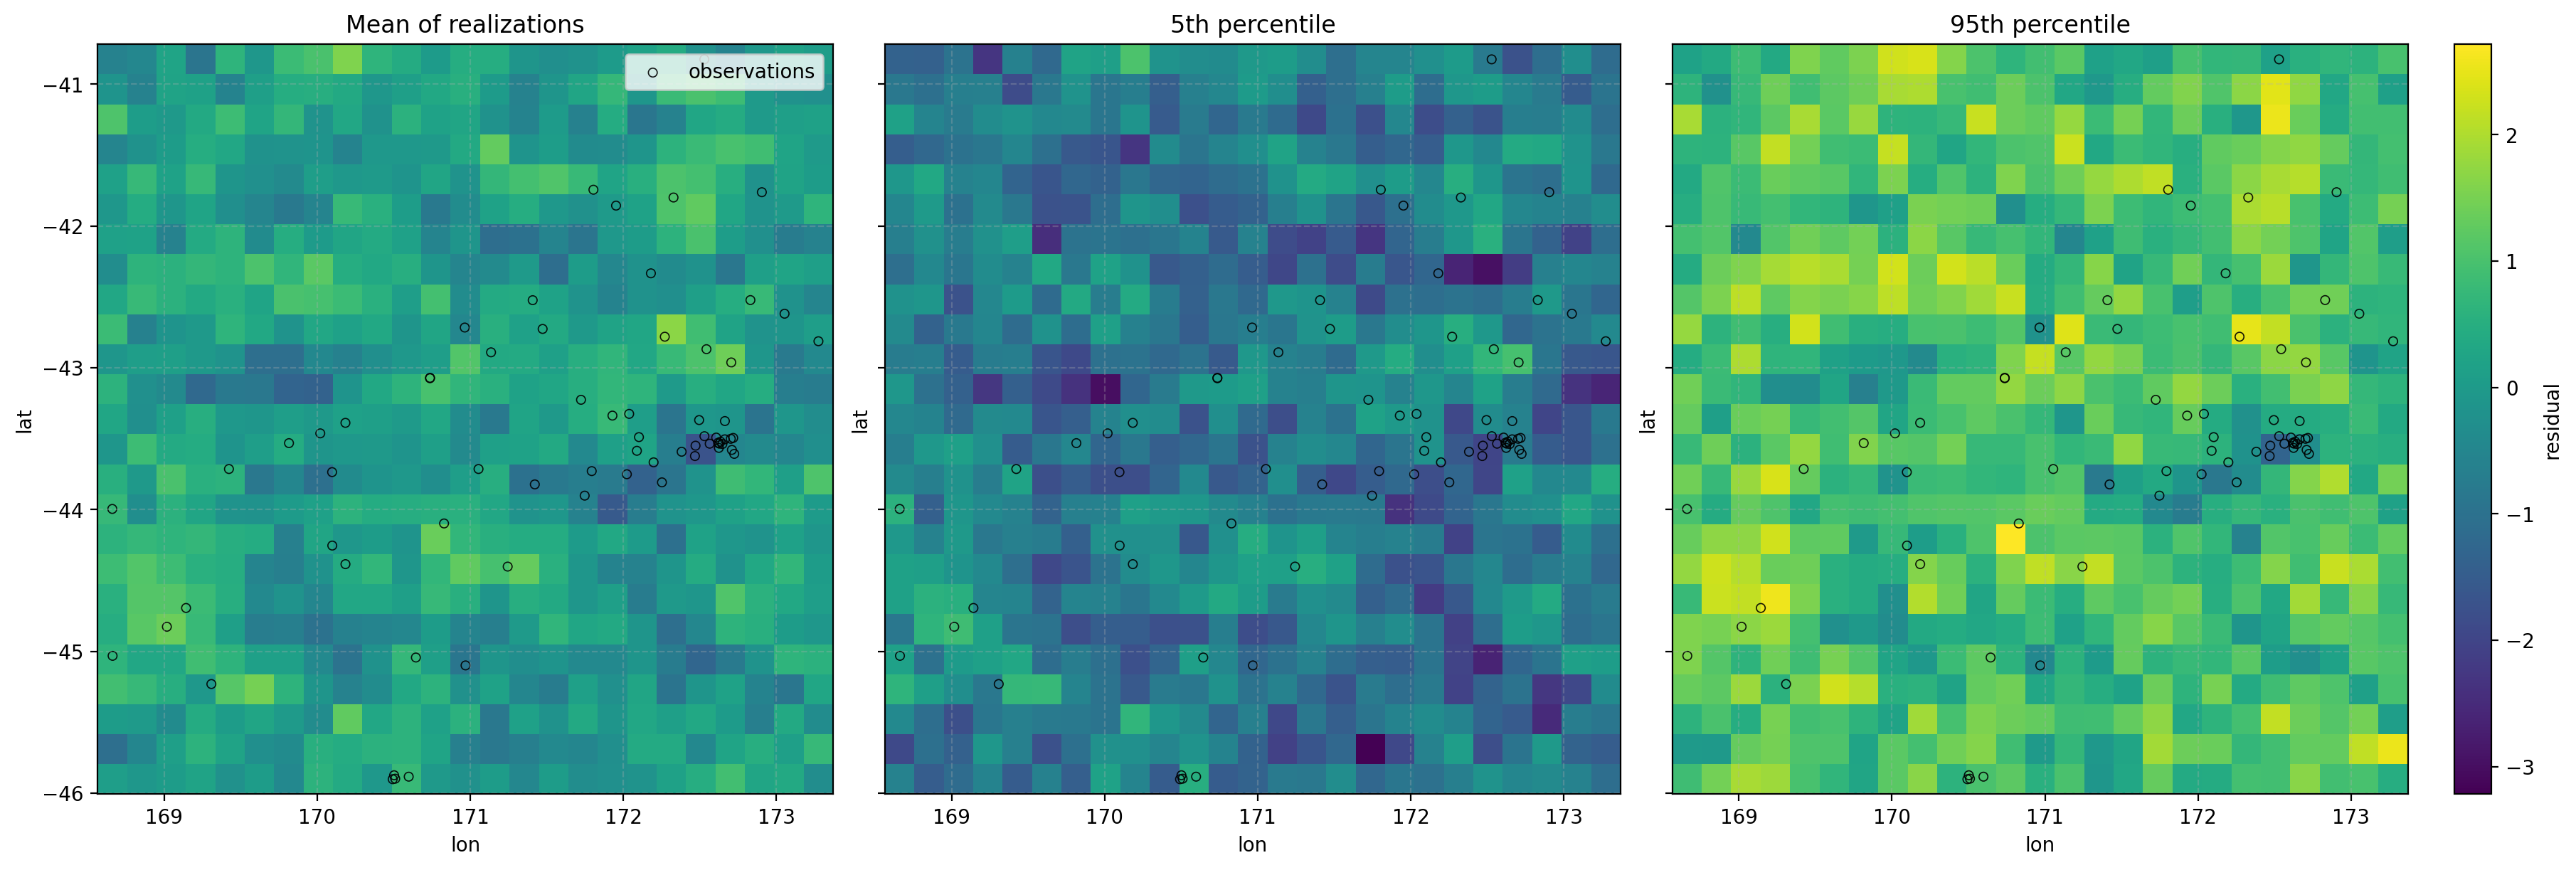

In [101]:
theta = (50,1) # exponential model: r = 85km, alpha = 1.0

# Build a grid of targets
xg = np.linspace(coords[:,0].min(), coords[:,0].max(), 25)
yg = np.linspace(coords[:,1].min(), coords[:,1].max(), 25)
XG, YG = np.meshgrid(xg, yg, indexing='ij')
T = np.column_stack([XG.ravel(), YG.ravel()])

# Simulate 2 realizations on normal-score scale with GLS mean
sims, sims_ns = sgs_simple_kriging(
    values=values,
    coords=coords,
    targets=T,
    model_family='correlation',
    model_type='exponential',
    theta=theta,
    params=None,                # correlation family
    sigma2=None,                # use 1 (normal-score)
    distance_type='geographic',
    mean=np.mean(values),
    n_realizations=4,
    transform='none',
    random_state=123,
    max_neighbors=64
)

# Plot quantiles of realizations
# Quantiles across realizations
mean_flat = np.nanmean(sims, axis=0)
p05_flat  = np.nanpercentile(sims, 5, axis=0)
p95_flat  = np.nanpercentile(sims, 95, axis=0)

# Reshape to grid
MEAN = mean_flat.reshape(XG.shape)
P05  = p05_flat.reshape(XG.shape)
P95  = p95_flat.reshape(XG.shape)

# Shared color scale
vmin = np.nanmin([MEAN.min(), P05.min(), P95.min()])
vmax = np.nanmax([MEAN.max(), P05.max(), P95.max()])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('viridis')

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=200, sharex=True, sharey=True, constrained_layout=True)
titles = ["Mean of realizations", "5th percentile", "95th percentile"]
fields = [MEAN, P05, P95]

mappable = None
for ax, Z, title in zip(axes, fields, titles):
    m = ax.pcolormesh(YG, XG, Z, shading="auto", cmap=cmap, norm=norm)
    mappable = m
    if coords is not None:
        ax.scatter(
            coords[:, 1], coords[:, 0],
            facecolors="none", edgecolors="k",
            s=20, linewidths=0.6, alpha=0.9, label="observations"
        )
    ax.set_title(title)
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.grid(True, linestyle="--", alpha=0.3)
cb = fig.colorbar(mappable, ax=axes, fraction=0.05, pad=0.02)
cb.set_label('residual')
if coords is not None:
    axes[0].legend(loc="upper right", frameon=True)
plt.show()

# 5.0 Simple Kriging Example 4: Sequential Gaussian Simulation (Custom)

## 5.1 Compute SGS on Custom Kernel

In [14]:
# Get Self-pairwise Distances for SGS
D_nn_E, D_nt_E = pairwise_distances(coords = im_dwbar_test[['lat','lon']], targets = target_latlon, distance_type = "geographic")
D_tt_E, _ = pairwise_distances(coords=target_latlon, targets=target_latlon, distance_type="geographic")

D_nn_S, D_nt_S = pairwise_distances(coords = im_dwbar_test[['vs30']], targets = target_vs30, distance_type = "euclidean")
D_tt_S, _ = pairwise_distances(coords=target_vs30, targets=target_vs30, distance_type="euclidean")

D_nn_A, D_nt_A = pairwise_distances(coords = im_dwbar_test[['epicenter_azimuth']], targets = target_angular, distance_type = "angular")
D_tt_A, _ = pairwise_distances(coords=target_angular, targets=target_angular, distance_type="angular")

# create dictionary of pairwise distances with Keys recognized by custom_kernel
blocks_nn = {"E": D_nn_E, "S": D_nn_S, "A": D_nn_A}
blocks_nt = {"E": D_nt_E, "S": D_nt_S, "A": D_nt_A}
blocks_tt = {"E": D_tt_E, "S": D_tt_S, "A": D_tt_A}

# Build/merge blocks for SGS
blocks_all = build_blocks_all(blocks_nn, blocks_nt, blocks_tt)

# Example theta and variance
theta = (40, 0.4, 20, 169, 0.4)   # (lE, gammaE, lS, cA, w)
sigma2_corr = float(np.var(values, ddof=1))

# call custom function: note we use the 'E' pairwise distance to determine max considered pairs
sims = sgs_simple_kriging_custom_corr(
    values=values,               # (n,)
    blocks_all=blocks_all,       # dict of (N,N) blocks (N=n+m)
    n_obs=len(values),
    custom_kernel=kernel_MpEAS,
    theta=theta,
    sigma2=sigma2_corr,
    n_realizations=4,
    mean=np.mean(values),                  # or 0.0 on standardized scale
    random_state=123,
    jitter=1e-10,
    max_neighbors= 128,
    neighbor_metric='E'
)

SGS realizations:   0%|          | 0/4 [00:00<?, ?it/s]

nodes (realization 1/4):   0%|          | 0/4675 [00:00<?, ?it/s]

nodes (realization 2/4):   0%|          | 0/4675 [00:00<?, ?it/s]

nodes (realization 3/4):   0%|          | 0/4675 [00:00<?, ?it/s]

nodes (realization 4/4):   0%|          | 0/4675 [00:00<?, ?it/s]

## 5.2 Plot of results

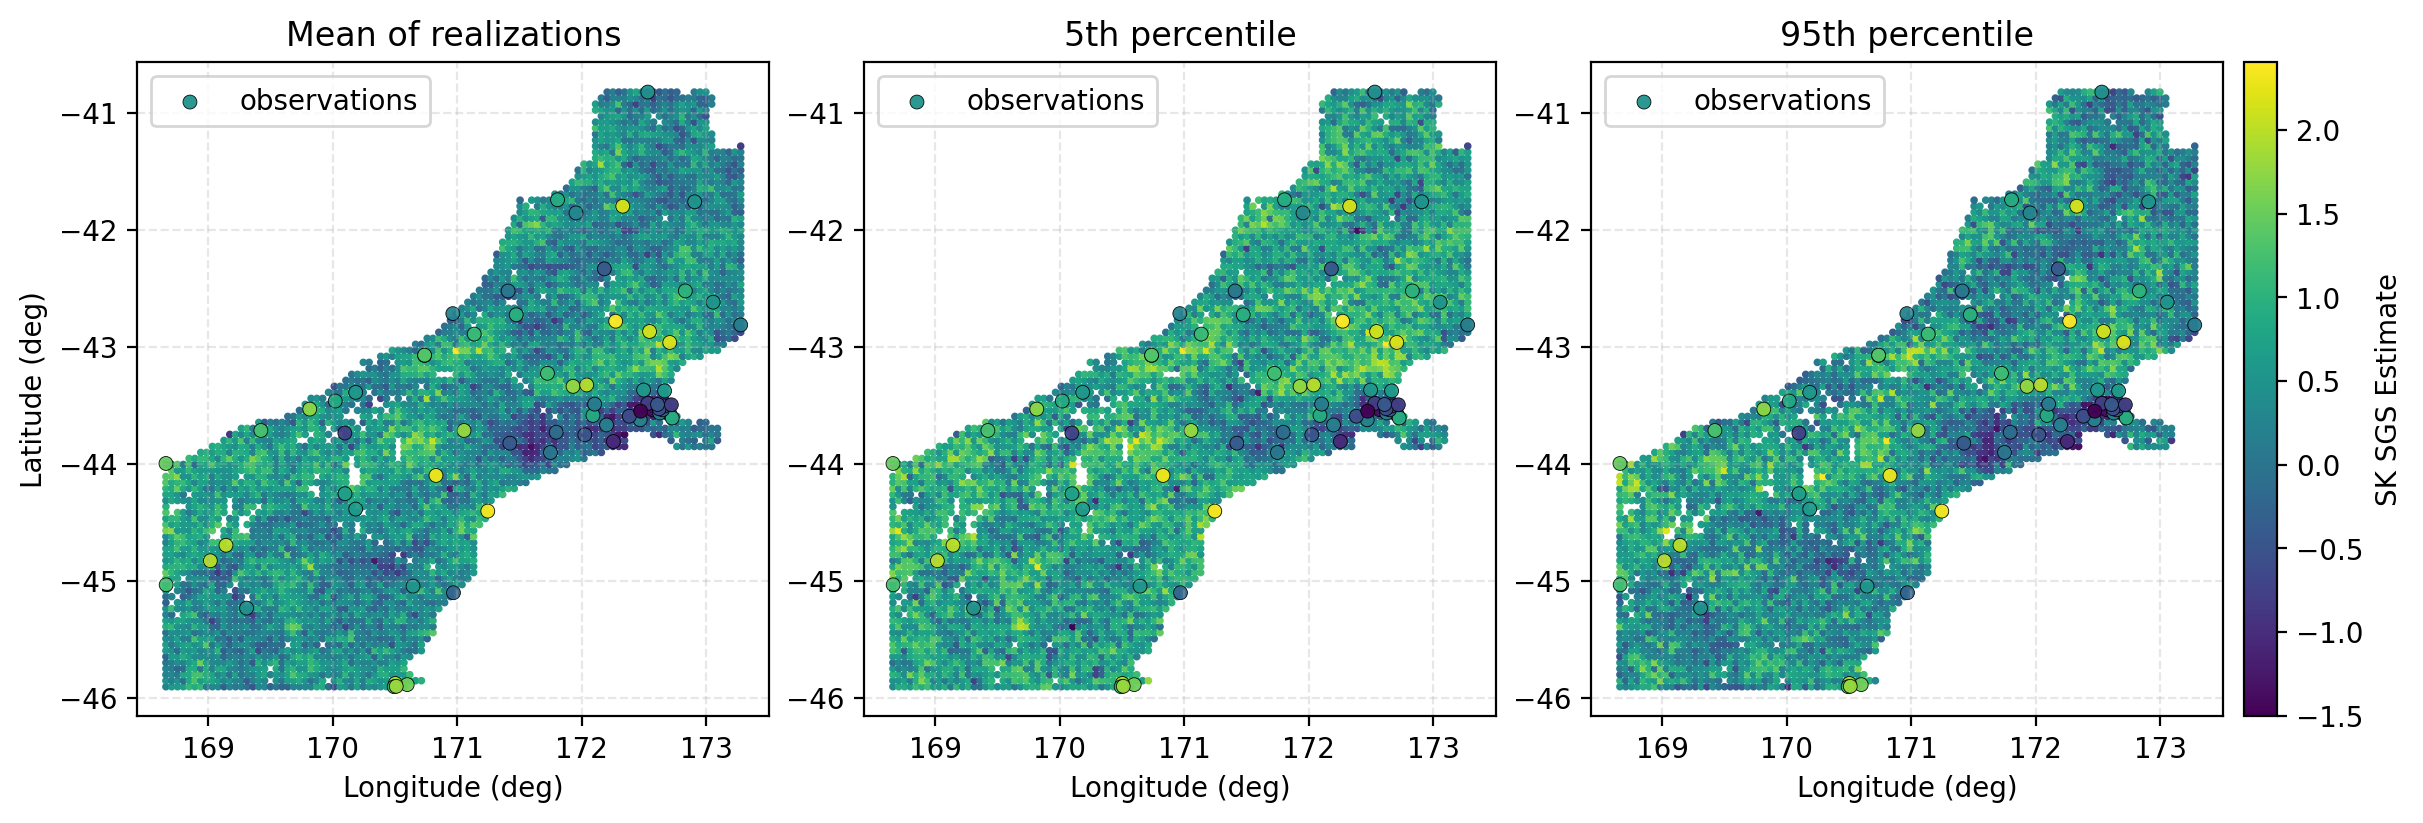

In [26]:
# compute percentiles
mean_flat = np.nanmean(sims, axis=0)
p05_flat  = np.nanpercentile(sims, 5, axis=0)
p95_flat  = np.nanpercentile(sims, 95, axis=0)

# Plot
fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=200, constrained_layout=True)

# mean
sc0 = ax[0].scatter(target_latlon[:, 1], target_latlon[:, 0], c=mean_flat, cmap='viridis', s=3)
ax[0].scatter(coords[:, 1], coords[:, 0], c=values, cmap='viridis', s=25, edgecolor="k", linewidths=0.3, alpha=0.95, label="observations")
ax[0].set_xlabel("Longitude (deg)")
ax[0].set_ylabel("Latitude (deg)")
ax[0].grid(True, linestyle="--", alpha=0.3)
ax[0].legend(loc="upper left", frameon=True)
ax[0].set_title('Mean of realizations')

# 5 percentile
ax[1].scatter(target_latlon[:, 1], target_latlon[:, 0], c = p05_flat, cmap='viridis', s=3)
ax[1].scatter(coords[:, 1], coords[:, 0], c=values, cmap='viridis', s=25, edgecolor="k", linewidths=0.3, alpha=0.95, label="observations")
ax[1].set_xlabel("Longitude (deg)")
ax[1].grid(True, linestyle="--", alpha=0.3)
ax[1].legend(loc="upper left", frameon=True)
ax[1].set_title('5th percentile')

# 95 percentile
ax[2].scatter(target_latlon[:, 1], target_latlon[:, 0], c = p95_flat, cmap='viridis', s=3)
ax[2].scatter(coords[:, 1], coords[:, 0], c=values, cmap='viridis', s=25, edgecolor="k", linewidths=0.3, alpha=0.95, label="observations")
ax[2].set_xlabel("Longitude (deg)")
ax[2].grid(True, linestyle="--", alpha=0.3)
ax[2].legend(loc="upper left", frameon=True)
ax[2].set_title('95th percentile')

cb1 = plt.colorbar(sc0, ax=ax, pad=0.01, fraction=0.05)
cb1.set_label("SK SGS Estimate")
plt.show(fig)

# 6.0 Simple Kriging Example 5: 1D Sequential Gaussian Simulation

## 6.1 Estimation of Variogram Parameters

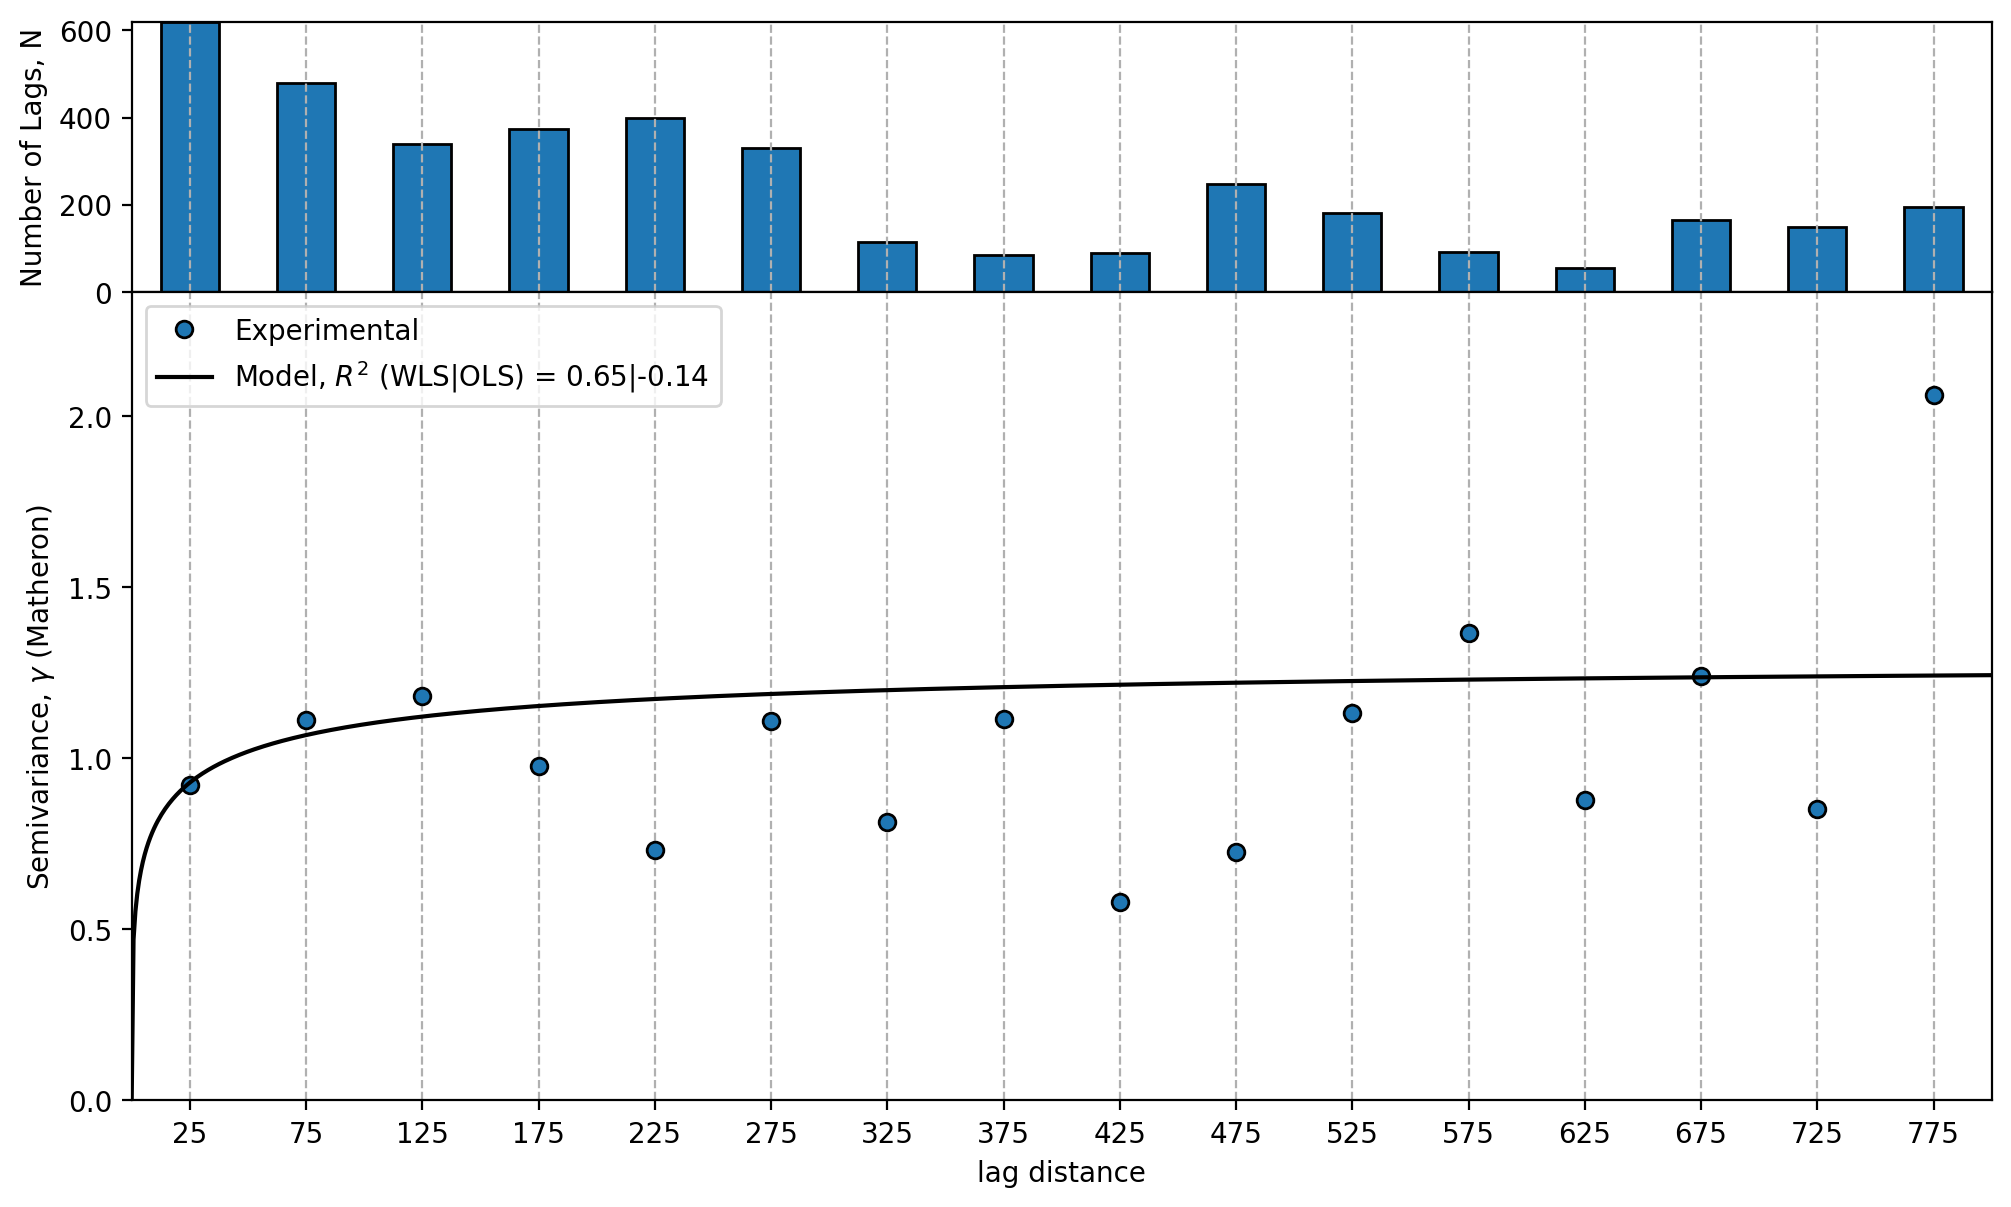

In [80]:
im_dwbar_test = im_dwbar.loc[:67]

estimator = "Matheron"
model = "powered_exponential"
weight_fn = 'exponential weighting'
weight_params = [50]
xmax_factor = 1
family = 'variogram'
distance_type = 'euclidean'

# get parameters/fit estiamte
h_lag, n_obs, gamma, params, r2_wls, r2_ols = variofit(values = im_dwbar_test['pSA_1.0'], coordinates = im_dwbar_test[['vs30']], distance_type = distance_type, max_distance = 800, bin_size = 50, estimator_type= estimator, model_type = model, weight_fn = weight_fn, weight_params = weight_params, xmax_factor=xmax_factor, fix_sill = False, plot = True)

## 6.2 Compute SGS SK

In [81]:
# get theta from previously
theta = theta_from_params(params, model, family='variogram')

# Prepare data for 1D Euclidean SK (x = vs30)
z = im_dwbar_test['pSA_1.0'].to_numpy(dtype=float)
X = im_dwbar_test[['vs30']].to_numpy(dtype=float)

# Define array for predictions on vs30
vmin, vmax = float(X.min()), float(X.max())
span = vmax - vmin if vmax > vmin else 1.0
T = np.linspace(vmin - 0.05*span, vmax + 0.05*span, 400).reshape(-1, 1)  # targets (m,1)

sims, sims_ns = sgs_simple_kriging(
    values=values,
    coords=im_dwbar_test[['vs30']],
    targets=T,
    model_family='variogram',
    model_type=model,
    theta=theta,
    params=params,                # correlation family
    sigma2=None,                # use 1 (normal-score)
    distance_type='euclidean',
    mean=np.mean(values),
    n_realizations=10,
    transform='none',
    random_state=123,
    max_neighbors=192
)

SGS realizations:   0%|          | 0/10 [00:00<?, ?it/s]

nodes (realization 1/10):   0%|          | 0/400 [00:00<?, ?it/s]

nodes (realization 2/10):   0%|          | 0/400 [00:00<?, ?it/s]

nodes (realization 3/10):   0%|          | 0/400 [00:00<?, ?it/s]

nodes (realization 4/10):   0%|          | 0/400 [00:00<?, ?it/s]

nodes (realization 5/10):   0%|          | 0/400 [00:00<?, ?it/s]

nodes (realization 6/10):   0%|          | 0/400 [00:00<?, ?it/s]

nodes (realization 7/10):   0%|          | 0/400 [00:00<?, ?it/s]

nodes (realization 8/10):   0%|          | 0/400 [00:00<?, ?it/s]

nodes (realization 9/10):   0%|          | 0/400 [00:00<?, ?it/s]

nodes (realization 10/10):   0%|          | 0/400 [00:00<?, ?it/s]

## 6.3 Plot

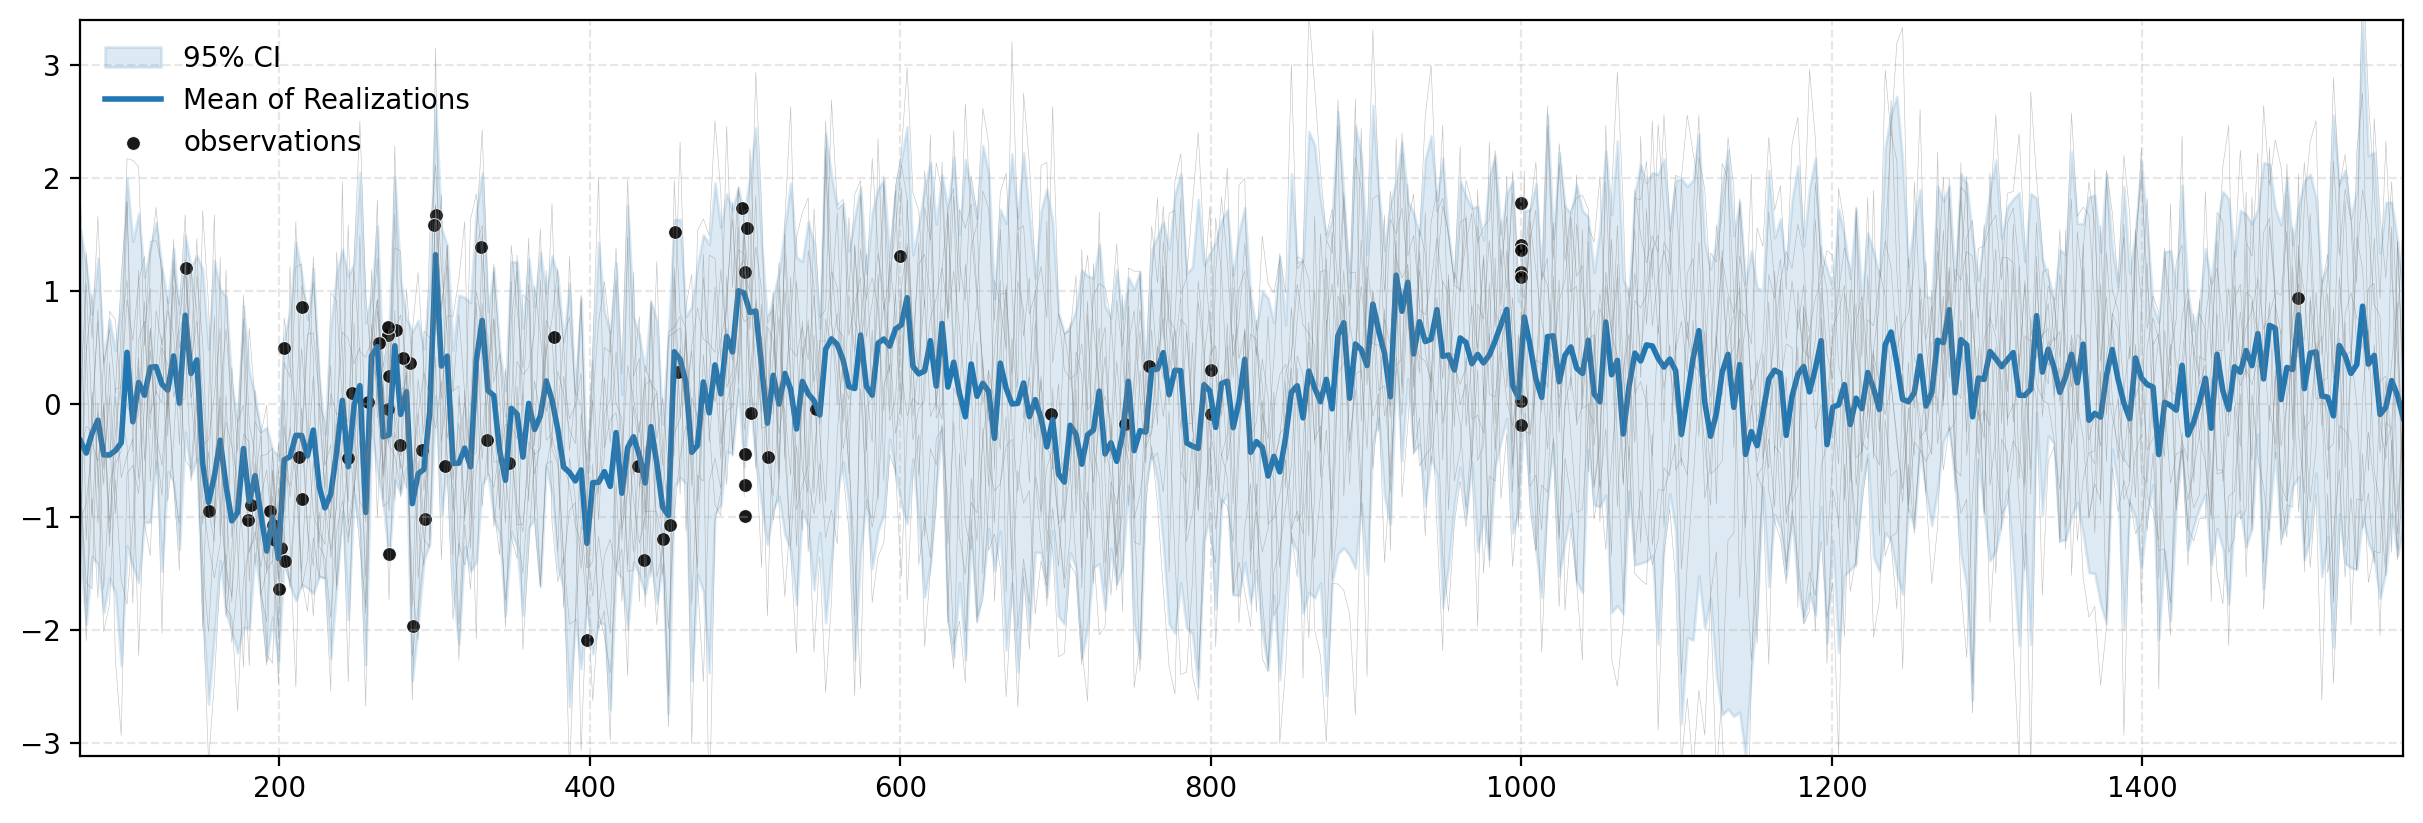

In [86]:
# compute percentiles
mean_flat = np.nanmean(sims, axis=0)
p05_flat  = np.nanpercentile(sims, 5, axis=0)
p95_flat  = np.nanpercentile(sims, 95, axis=0)

fig, ax = plt.subplots(figsize=(12,4), dpi=200, constrained_layout=True)
ax.fill_between(T.ravel(), p05_flat, p95_flat, color='tab:blue', alpha=0.15, label='95% CI')
ax.plot(T.ravel(), mean_flat, '-', color='tab:blue', lw=2, label='Mean of Realizations')
for i in range(len(sims)):
    ax.plot(T.ravel(), sims[i], '-', color='tab:gray', lw=0.2, alpha=0.5)

ax.scatter(X.ravel(), z, s=25, c='k', edgecolor='w', linewidths=0.4, alpha=0.9, label='observations')
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_xlim(min(T.ravel()), max(T.ravel()))
ax.set_ylim(min(p05_flat), max(p95_flat))
ax.legend(loc='best', frameon=False)
plt.show()